In [13]:
import numpy as np
import pandas as pd
import time

from matplotlib import pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation as LDA, TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans
from sklearn.preprocessing import Normalizer
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score, calinski_harabaz_score

rng = np.random

In [2]:
headlines_df = pd.read_csv('../data/news_headlines.csv')

headlines_df.shape
headlines_df.loc[rng.choice(np.arange(len(headlines_df)), 10), :]

,publish_date,headline_text
17638,20030722,ethanol industry gets 10m top up
342397,20080918,council not backing breakwater cove development
573455,20110220,leaders offer sympathies to slain soldiers family
495323,20100308,police flying squad targeting alcohol fuelled
902836,20150122,circular quay reopens after suspicious object ...
156979,20051225,millions celebrate christmas in china
650264,20121204,nefa calls for guarantee no logging in nationa...
895503,20150805,high court hears appeal of miner travers duncan
32763,20030413,5 more sars deaths in hk
596033,20110830,allan praises outgoing gibbons


In [3]:
# break dataset by year
print('min date = %d\nmax date = %d' % (np.min(headlines_df['publish_date']), np.max(headlines_df['publish_date'])))

df_year = {}

for y in np.arange(2003, 2018):
    subdf = headlines_df[(headlines_df['publish_date'] >= y * 1e4) & (headlines_df['publish_date'] < (y + 1) * 1e4)]
    df_year[y] = subdf
    
    print('year %d length = %d' % (y, len(subdf)))

df_year.keys()

min date = 20030219
max date = 20171231
year 2003 length = 59343
year 2004 length = 65975
year 2005 length = 66320
year 2006 length = 61568
year 2007 length = 69431
year 2008 length = 71591
year 2009 length = 68867
year 2010 length = 67715
year 2011 length = 69919
year 2012 length = 78547
year 2013 length = 81016
year 2014 length = 73361
year 2015 length = 70004
year 2016 length = 52162
year 2017 length = 44182


dict_keys([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

In [4]:
n_comps = 200
norm = 'l2'
metric = 'minkowski'
p = 2 # for Minkowski metric
stop_words = 'english'

subdf_year = 2017

In [5]:
tsvd = TruncatedSVD(n_components=n_comps)
norm = Normalizer(norm=norm)
lsa_pipe = make_pipeline(tsvd, norm)

In [6]:
counter_1gram = CountVectorizer(stop_words=stop_words)

counter_1gram.fit(df_year[subdf_year]['headline_text'])

vocab_1gram = pd.DataFrame.from_dict(counter_1gram.vocabulary_, orient='index')

vocab_1gram.columns = ['count']
#vocab_df.sort_values(by='count', ascending=False)

In [7]:
counter_2gram = CountVectorizer(stop_words=stop_words, ngram_range=(2, 2))

counter_2gram.fit(df_year[subdf_year]['headline_text'])

vocab_2gram = pd.DataFrame.from_dict(counter_2gram.vocabulary_, orient='index')

vocab_2gram.columns = ['count']

In [8]:
counter_3gram = CountVectorizer(stop_words=stop_words, ngram_range=(3, 3))

counter_3gram.fit(df_year[subdf_year]['headline_text'])

vocab_3gram = pd.DataFrame.from_dict(counter_3gram.vocabulary_, orient='index')

vocab_3gram.columns = ['count']

In [9]:
print(vocab_1gram.sort_values(by='count', ascending=False)[:20])
print(vocab_2gram.sort_values(by='count', ascending=False)[:20])
print(vocab_3gram.sort_values(by='count', ascending=False)[:20])

             count
zygar        22526
zverev       22525
zuul         22524
zushi        22523
zurakowski   22522
zuma         22521
zuleta       22520
zuckerbergs  22519
zuckerberg   22518
zucco        22517
zschech      22516
zou          22515
zoos         22514
zoologists   22513
zookeeper    22512
zoo          22511
zonta        22510
zones        22509
zone         22508
zonca        22507
                      count
zygar discusses      113006
zverev loss          113005
zverev indian        113004
zverev australian    113003
zuul spiked          113002
zushi stealing       113001
zurakowski wa        113000
zuma survives        112999
zuma south           112998
zuma quit            112997
zuma pledges         112996
zuleta favourite     112995
zuckerbergs vr       112994
zuckerberg dropping  112993
zucco vendetta       112992
zschech jailed       112991
zou mystery          112990
zoos sniffer         112989
zoos aquariums       112988
zookeeper london     112987
             

In [10]:
term_mat1g = counter_1gram.transform(df_year[2017]['headline_text'])
term_mat2g = counter_2gram.transform(df_year[2017]['headline_text'])
term_mat3g = counter_3gram.transform(df_year[2017]['headline_text'])

term_mat1g.shape, term_mat2g.shape, term_mat3g.shape

((44182, 22527), (44182, 113007), (44182, 110168))

**MDS is taking forever** (try again @ home)

In [ ]:
mds = MDS(metric=True, max_iter=300, n_jobs=4, dissimilarity='euclidean', eps=1e-3)

mds.fit(lsa_pipe.fit_transform(term_mat1g))

(n-grams contd)

In [12]:
feat1g = lsa_pipe.fit_transform(term_mat1g)
feat2g = lsa_pipe.fit_transform(term_mat3g)
feat3g = lsa_pipe.fit_transform(term_mat3g)

feat1g.shape, feat2g.shape, feat3g.shape

((44182, 200), (44182, 200), (44182, 200))

In [36]:
data = feat2g
k_values = np.arange(10, 31, 1)
km_scores_df = pd.DataFrame(columns=('k', 'inertia', 'silhouette', 'cali-hara'))

for k in k_values:
    km = MiniBatchKMeans(n_clusters=k, batch_size=8000)
    
    t0 = time.time()
    km.fit(data)
    
    print('k-Means k=%d completed in %.1fs' % (k, time.time() - t0))
    
    km_scores_df.loc[len(km_scores_df)] = [
        k, km.inertia_,
        silhouette_score(data, km.labels_, metric='euclidean', sample_size=int(0.2 * len(feat1g))),
        calinski_harabaz_score(data, km.labels_)
    ]

print('done')

k-Means k=10 completed in 1.8s
k-Means k=11 completed in 1.5s
k-Means k=12 completed in 1.7s
k-Means k=13 completed in 2.0s
k-Means k=14 completed in 1.4s
k-Means k=15 completed in 1.8s
k-Means k=16 completed in 1.5s
k-Means k=17 completed in 2.0s
k-Means k=18 completed in 1.8s
k-Means k=19 completed in 1.9s
k-Means k=20 completed in 2.1s
k-Means k=21 completed in 2.1s
k-Means k=22 completed in 1.5s
k-Means k=23 completed in 1.9s
k-Means k=24 completed in 2.5s
k-Means k=25 completed in 2.0s
k-Means k=26 completed in 2.0s
k-Means k=27 completed in 2.2s
k-Means k=28 completed in 3.1s
k-Means k=29 completed in 2.3s
k-Means k=30 completed in 2.5s
done


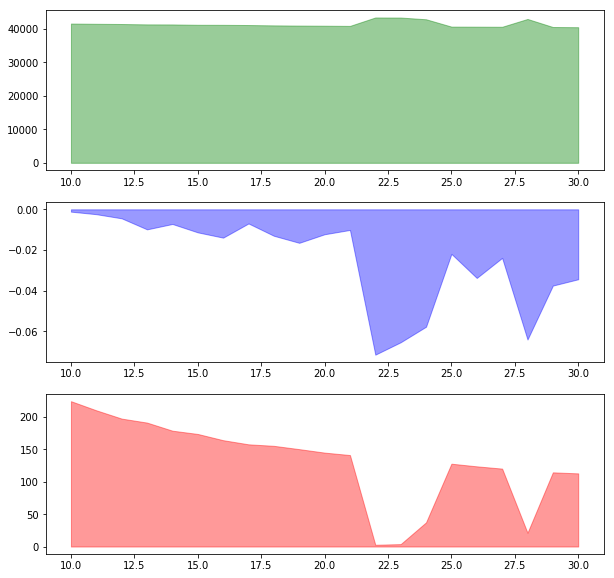

In [37]:
plt.figure(figsize=(10,10))
plt.subplot(3, 1, 1)
plt.fill_between(km_scores_df['k'], km_scores_df['inertia'], color='green', alpha=0.4)
plt.subplot(3, 1, 2)
plt.fill_between(km_scores_df['k'], km_scores_df['silhouette'], color='blue', alpha=0.4)
plt.subplot(3, 1, 3)
plt.fill_between(km_scores_df['k'], km_scores_df['cali-hara'], color='red', alpha=0.4)
plt.show()

In [ ]:
# 1-grams: very high inertia, increasing silhouette max 0.08, cali-hara around 400
# 2-grams: very high inertia, negative silhouette           , cali-hara decreasing, max ~120?
# 3-grams: very high inertia, negative silhouette           , cali-hara decreasing, max ~130?

In [ ]:
MiniBatchKMeans.fit??